<a href="https://colab.research.google.com/github/Lefkios/yolov8-adversarial-patch-defense/blob/main/Yolo_Patch_Opt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define path to your YOLOv8 model
YOLO_MODEL_PATH = "/content/drive/MyDrive/yolo_trained_models/2dod_checkpoints/best.pt"

In [ ]:
# Install Ultralytics YOLOv8
!pip install ultralytics

!pip install kornia
!pip install torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 22.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

# Helper Functions

##Create the Learnable Patch

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
patch_size = (80, 80)

# Learnable patch initialized with random values
patch = torch.rand(3, *patch_size, device=device, requires_grad=True)

# Setup optimizer
optimizer = torch.optim.Adam([patch], lr=0.05)

print(f"Patch shape: {patch.shape} | Device: {device}")


Patch shape: torch.Size([3, 80, 80]) | Device: cuda


## Apply Appearance Transformations

In [ ]:
import torchvision.transforms as T

appearance_transforms = T.Compose([
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    T.RandomPerspective(distortion_scale=0.5, p=0.5),
    T.GaussianBlur(3),
])

def apply_appearance_transforms(patch):
    return appearance_transforms(patch)



## EOT — Spatial + Projective Transformations

In [ ]:
import kornia

def apply_eot(patch):
    # Simulate different angles/scales
    affine = kornia.augmentation.RandomAffine(degrees=20, translate=0.1, scale=(0.8, 1.2))
    return affine(patch.unsqueeze(0)).squeeze(0)


## Add Patch to Image

In [ ]:
import torch
import random

def overlay_patch(image, patch, x_offset=None, y_offset=None):
    patched = image.clone()
    _, H_img, W_img = image.shape
    _, H_patch, W_patch = patch.shape

    # Calculate valid bounds
    max_y = H_img - H_patch
    max_x = W_img - W_patch

    if max_y < 0 or max_x < 0:
        raise ValueError("Patch is larger than the image.")

    # If no offsets are given, random position
    if x_offset is None:
        x_offset = random.randint(0, max_x)
    else:
        x_offset = min(max(x_offset, 0), max_x)

    if y_offset is None:
        y_offset = random.randint(0, max_y)
    else:
        y_offset = min(max(y_offset, 0), max_y)

    # Apply the patch
    patched[:, y_offset:y_offset + H_patch, x_offset:x_offset + W_patch] = patch
    return patched



# Load trained YOLOv8 model


In [ ]:
from ultralytics import YOLO

# Load trained YOLOv8 model
model = YOLO(YOLO_MODEL_PATH)
model.fuse()

model.model.to(device)
model.to(device)


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Model summary (fused): 92 layers, 25,886,080 parameters, 0 gradients, 78.9 GFLOPs


YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (m): ModuleList(
          (0-1): 2 x Bottleneck(
            (cv1): Conv(
              (conv): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (act): SiLU(inplace=True)
            )
            (cv2): Conv(
              (conv): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (act): SiLU(inplace=Tr

In [ ]:
from PIL import Image
from torchvision import transforms

image_path = "/content/drive/MyDrive/2dod/2dod/billboard01/images/train/rgb_0099.png"

# Standard image loader
def load_image_tensor(path):
    image = Image.open(path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize((640, 640)),  # YOLO input size
        transforms.ToTensor(),          # [0,1], shape [C,H,W]
    ])
    return transform(image).to(device)


In [ ]:
image_tensor = load_image_tensor(image_path)

In [ ]:
def overlay_patch(image, patch, x_offset=0, y_offset=0):
    patched_image = image.clone()
    _, H, W = image.shape
    ph, pw = patch.shape[1:]

    # Ensure patch fits
    if y_offset + ph > H or x_offset + pw > W:
        raise ValueError("Patch placement is outside image bounds.")

    patched_image[:, y_offset:y_offset+ph, x_offset:x_offset+pw] = patch
    return patched_image


 **YOLO - Understanding `preds[:, 4]` and `preds[:, 5:]`**

When we run:

out = model.model(patched_input)

preds = out[0]

we get a tensor shaped like [N, 85], where N is the number of predicted bounding boxes (usually 8400 for YOLOv5/8).

Each prediction row contains:

- preds[:, 0:4] → bounding box coordinates (x, y, width, height)

- preds[:, 4] → objectness score

 - Confidence that any object exists in the box

 - Ranges from 0 to 1

- preds[:, 5:] → class probabilities (usually 80 classes for COCO)

 - Confidence for each object class (e.g. car, person, traffic light)

 - These values are not yet normalized (softmax not applied)


# Simple adversarial patch optimization without EOT
- Applies the patch once on a single fixed image (no variation)
- Runs YOLO and extracts objectness scores
- Computes a loss to suppress detections (maximize confusion)
- Updates the patch using backpropagation

 No random transforms

### Adversarial Loss Objective (Detection Maximization)

In this code, we aim to **maximize the number of objects** detected by YOLO.

To do this, we use the following adversarial loss:

loss = -objectness.pow(2).sum()

What it does:

- objectness is the YOLO confidence score for each predicted object.

- We square these scores to emphasize confident detections.

- The negative sign means we’re maximizing those scores.

- The patch is optimized to encourage YOLO to detect more objects



In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import os

# Init patch and optimizer
patch1 = torch.rand_like(patch, requires_grad=True)
optimizer = torch.optim.Adam([patch1], lr=0.03)

#Setup for saving best patch
LOSS_DIRECTION = "minimize"
best_loss = float("inf")
best_patch1 = patch1.clone().detach().cpu()

#Optimization loop
for step in range(1000):
    optimizer.zero_grad()

    # Overlay patch on image
    patched = overlay_patch(image_tensor, patch1, x_offset=10, y_offset=400)
    patched_input = patched.unsqueeze(0)

    # Run model
    out = model.model(patched_input)
    preds = out[0]
    objectness = preds[:, 4]

    # Adversarial loss
    loss = -objectness.pow(2).sum()

    #Backprop + update
    loss.backward()
    optimizer.step()
    patch1.data.clamp_(0, 1)

    #Save best patch
    is_better = loss.item() < best_loss if LOSS_DIRECTION == "minimize" else loss.item() > best_loss
    if is_better:
        best_loss = loss.item()
        best_patch1 = patch1.clone().detach().cpu()

    # Log
    detections = (objectness > 0.3).sum().item()
    if step % 10 == 0:
        print(f"Step {step} | Loss: {loss.item():.4f} | Detections: {detections}")


Step 0 | Loss: -3.3860 | Detections: 9
Step 10 | Loss: -3.3864 | Detections: 9
Step 20 | Loss: -3.3866 | Detections: 9
Step 30 | Loss: -3.3868 | Detections: 9
Step 40 | Loss: -3.3868 | Detections: 9
Step 50 | Loss: -3.3869 | Detections: 9
Step 60 | Loss: -3.3870 | Detections: 9
Step 70 | Loss: -3.3871 | Detections: 9
Step 80 | Loss: -3.3871 | Detections: 9
Step 90 | Loss: -3.3872 | Detections: 9
Step 100 | Loss: -3.3872 | Detections: 9
Step 110 | Loss: -3.3873 | Detections: 9
Step 120 | Loss: -3.3873 | Detections: 9
Step 130 | Loss: -3.3874 | Detections: 9
Step 140 | Loss: -3.3875 | Detections: 9
Step 150 | Loss: -3.3877 | Detections: 9
Step 160 | Loss: -3.3878 | Detections: 9
Step 170 | Loss: -20.6485 | Detections: 35
Step 180 | Loss: -31.6919 | Detections: 46
Step 190 | Loss: -39.5288 | Detections: 59
Step 200 | Loss: -41.6108 | Detections: 66
Step 210 | Loss: -44.7662 | Detections: 66
Step 220 | Loss: -46.5120 | Detections: 67
Step 230 | Loss: -48.0919 | Detections: 68
Step 240 | Lo

KeyboardInterrupt: 

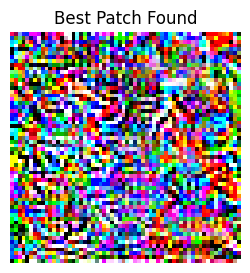

Best patched image saved to: /content/drive/MyDrive/yolo_patch/simple_patched.png


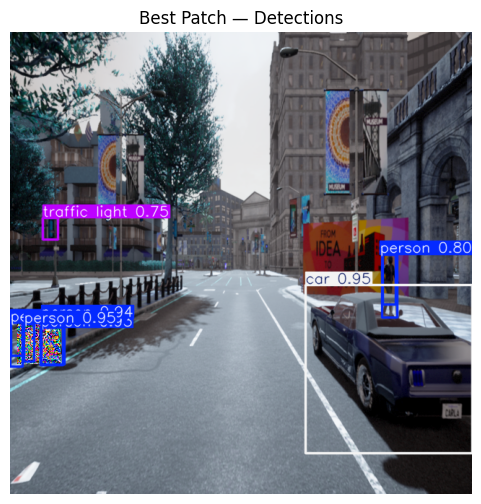

In [ ]:
#Visualize the best patch
plt.figure(figsize=(3, 3))
plt.imshow(best_patch1.permute(1, 2, 0).numpy())
plt.title("Best Patch Found")
plt.axis("off")
plt.show()

# Overlay best patch on image
patched = overlay_patch(image_tensor, best_patch1.to(image_tensor.device), x_offset=10, y_offset=400)
results = model(patched.unsqueeze(0), verbose=False)
img_with_boxes = results[0].plot()
img_rgb = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)

#Save to Drive
save_path = "/content/drive/MyDrive/yolo_patch/simple_patched.png"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
Image.fromarray(img_rgb).save(save_path)
print(f"Best patched image saved to: {save_path}")

#Show final result
plt.figure(figsize=(6, 6))
plt.imshow(img_rgb)
plt.title("Best Patch — Detections")
plt.axis("off")
plt.show()


# Patch Optimization with EOT and Multi-View Averaging


This section optimizes a new patch (`patch2`) to manipulate YOLO's detections under realistic variations.

Key components of this setup:

- **Random Transforms (EOT + Appearance)**:
  - Every step, we simulate random transformations to mimic real-world variations in appearance and viewpoint.
  - This makes the patch **robust to different conditions**.

- **Multi-View Loss Averaging**:
  - We evaluate the patch over `num_views` (e.g., 5) randomized inputs.
  - The total loss and detection count are averaged across these views.
  - This helps the patch generalize better, rather than overfitting to a single configuration.

This strategy is useful for crafting patches that remain effective under **environmental uncertainty**, such as lighting, scale, and viewpoint shifts.



Loss Mode (means vs sum)  
- mean: Averages the squared scores → makes loss stable even if the number of detections changes.

- sum: Adds all squared scores → loss becomes larger if there are more detections.

In short:

- Use sum if you want to maximize or minimize total detections.

- Use mean if you want a stable loss, not affected by how many detections there are.

In [ ]:
import matplotlib.pyplot as plt

patch2 = torch.rand_like(patch, requires_grad=True)
optimizer = torch.optim.Adam([patch2], lr=0.03)

num_views = 5
num_steps = 600
LOSS_MODE = "sum"      # "mean" or "sum"
LOSS_DIRECTION = "minimize"

#Initialize tracking for best patch
best_patch2 = patch2.clone().detach().cpu()
best_loss = float("inf") if LOSS_DIRECTION == "minimize" else -float("inf")

for step in range(num_steps):
    optimizer.zero_grad()
    total_loss = 0.0
    total_detections = 0

    for _ in range(num_views):
        # 1 Random transforms
        t_patch = apply_appearance_transforms(patch2)
        t_patch = apply_eot(t_patch)

        # 2️ Overlay
        patched = overlay_patch(image_tensor, t_patch, x_offset=300, y_offset=300)
        patched_input = patched.unsqueeze(0)

        # 3 YOLO forward pass
        out = model.model(patched_input)
        preds = out[0]
        objectness = preds[:, 4]

        # 4 Compute loss
        if objectness.numel() == 0:
            loss = torch.tensor(0.0, dtype=torch.float32, device=patch2.device, requires_grad=True)
        else:
            if LOSS_MODE == "mean":
                loss = -objectness.pow(2).mean()
            elif LOSS_MODE == "sum":
                loss = -objectness.pow(2).sum()
            else:
                raise ValueError("Invalid LOSS_MODE. Use 'mean' or 'sum'.")

        total_loss += loss
        total_detections += (objectness > 0.3).sum().item()

    # 5 Average across views
    avg_loss = total_loss / num_views
    avg_detections = total_detections / num_views

    # 6 Backprop
    avg_loss.backward()
    optimizer.step()
    patch2.data.clamp_(0, 1)

    # 7 Track best patch
    is_better = avg_loss.item() < best_loss if LOSS_DIRECTION == "minimize" else avg_loss.item() > best_loss
    if is_better:
        best_loss = avg_loss.item()
        best_patch2 = patch2.clone().detach().cpu()

    # Logging
    if step % 10 == 0:
        print(f"Step {step} | Mode: {LOSS_MODE} | Loss: {avg_loss.item():.4f} | Avg Detections: {avg_detections:.2f}")


Step 0 | Mode: sum | Loss: -4.1558 | Avg Detections: 10.00
Step 10 | Mode: sum | Loss: -4.1809 | Avg Detections: 10.20
Step 20 | Mode: sum | Loss: -4.1947 | Avg Detections: 10.00
Step 30 | Mode: sum | Loss: -4.2243 | Avg Detections: 10.00
Step 40 | Mode: sum | Loss: -4.2445 | Avg Detections: 10.00
Step 50 | Mode: sum | Loss: -4.2877 | Avg Detections: 10.00
Step 60 | Mode: sum | Loss: -4.2504 | Avg Detections: 10.00
Step 70 | Mode: sum | Loss: -4.2710 | Avg Detections: 10.00
Step 80 | Mode: sum | Loss: -4.3117 | Avg Detections: 10.00
Step 90 | Mode: sum | Loss: -4.2218 | Avg Detections: 10.00
Step 100 | Mode: sum | Loss: -4.2789 | Avg Detections: 10.20
Step 110 | Mode: sum | Loss: -4.2826 | Avg Detections: 10.20
Step 120 | Mode: sum | Loss: -4.2232 | Avg Detections: 10.00
Step 130 | Mode: sum | Loss: -4.2654 | Avg Detections: 10.20
Step 140 | Mode: sum | Loss: -4.3098 | Avg Detections: 10.20
Step 150 | Mode: sum | Loss: -4.2998 | Avg Detections: 10.20
Step 160 | Mode: sum | Loss: -4.291

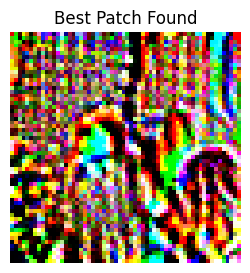

Best patched image saved to: /content/drive/MyDrive/yolo_patch/eot5_patched.png


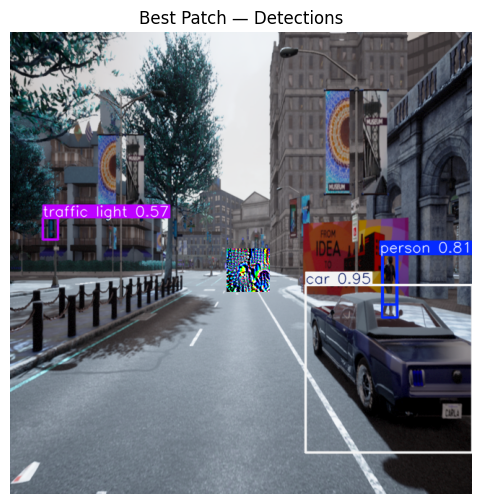

In [ ]:
#Visualize the best patch
plt.figure(figsize=(3, 3))
plt.imshow(best_patch2.permute(1, 2, 0).numpy())
plt.title("Best Patch Found")
plt.axis("off")
plt.show()

# Overlay best patch on image
patched = overlay_patch(image_tensor, best_patch2.to(image_tensor.device), x_offset=300, y_offset=300)
results = model(patched.unsqueeze(0), verbose=False)
img_with_boxes = results[0].plot()
img_rgb = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)

#Save to Drive
save_path = "/content/drive/MyDrive/yolo_patch/eot5_patched.png"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
Image.fromarray(img_rgb).save(save_path)
print(f"Best patched image saved to: {save_path}")

#Show final result
plt.figure(figsize=(6, 6))
plt.imshow(img_rgb)
plt.title("Best Patch — Detections")
plt.axis("off")
plt.show()

# Minimizing detections

In [ ]:
patch4 = torch.rand((3, 100, 100), requires_grad=True, device=device)
optimizer = torch.optim.Adam([patch4], lr=0.03)

best_loss = float("inf")
best_detections = float("inf")

best_patch4 = patch4.clone().detach().cpu()

for step in range(300):
    optimizer.zero_grad()
    total_loss = 0.0
    total_detections = 0

    for _ in range(5):  # num_views
        # EOT + appearance
        t_patch = apply_appearance_transforms(patch4)
        t_patch = apply_eot(t_patch)

        # Overlay on image
        patched = overlay_patch(image_tensor, t_patch, x_offset=300, y_offset=300)
        patched_input = patched.unsqueeze(0)

        # Raw output
        preds = model.model(patched_input)[0]
        objectness = preds[:, 4]

        # Loss (minimize detections)
        loss = objectness.pow(2).sum()
        total_loss += loss
        total_detections += (objectness > 0.3).sum().item()

    avg_loss = total_loss / 5  # Dividing by number of views (should match outer loop count)
    avg_detections = total_detections / 5

    avg_loss.backward()
    optimizer.step()
    patch4.data.clamp_(0, 1)

    # Save best patch based on detections
    if avg_detections < best_detections:
      best_detections = avg_detections
      best_patch4 = patch4.clone().detach().cpu()

    if step % 10 == 0:
        print(f"Step {step} | Loss: {avg_loss.item():.4f} | Detections: {avg_detections:.2f}")



Step 0 | Loss: 1.7988 | Detections: 6.20
Step 10 | Loss: 1.5960 | Detections: 5.40
Step 20 | Loss: 1.7962 | Detections: 6.80
Step 30 | Loss: 0.8046 | Detections: 2.80
Step 40 | Loss: 1.4007 | Detections: 5.20
Step 50 | Loss: 1.0408 | Detections: 3.60
Step 60 | Loss: 0.6717 | Detections: 2.20
Step 70 | Loss: 1.2794 | Detections: 4.60
Step 80 | Loss: 1.4475 | Detections: 5.60
Step 90 | Loss: 0.5546 | Detections: 2.00
Step 100 | Loss: 1.1364 | Detections: 4.40
Step 110 | Loss: 0.7742 | Detections: 2.40
Step 120 | Loss: 1.4307 | Detections: 5.00
Step 130 | Loss: 1.4488 | Detections: 5.00
Step 140 | Loss: 1.3994 | Detections: 5.00
Step 150 | Loss: 0.9490 | Detections: 3.80
Step 160 | Loss: 0.3725 | Detections: 1.00
Step 170 | Loss: 0.8350 | Detections: 2.40
Step 180 | Loss: 0.9968 | Detections: 3.80
Step 190 | Loss: 0.6579 | Detections: 1.60
Step 200 | Loss: 0.4307 | Detections: 1.40
Step 210 | Loss: 0.3234 | Detections: 0.80
Step 220 | Loss: 0.7944 | Detections: 2.60
Step 230 | Loss: 1.346

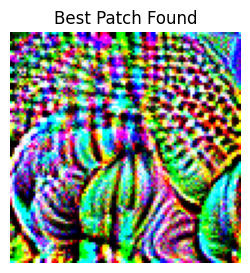

Best patch had 0.00 detections
Best patched image saved to: /content/drive/MyDrive/yolo_patch/Min_Detect_patched.png


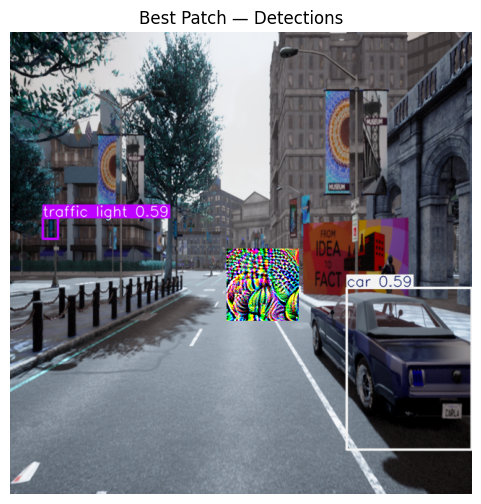

In [ ]:
#Visualize the best patch
plt.figure(figsize=(3, 3))
plt.imshow(best_patch4.permute(1, 2, 0).numpy())
plt.title("Best Patch Found")
plt.axis("off")
plt.show()

print(f"Best patch had {best_detections:.2f} detections")


# Overlay best patch on image
patched = overlay_patch(image_tensor, best_patch4.to(image_tensor.device), x_offset=300, y_offset=300)
results = model(patched.unsqueeze(0), verbose=False)
img_with_boxes = results[0].plot()
img_rgb = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)

#Save to Drive
save_path = "/content/drive/MyDrive/yolo_patch/Min_Detect_patched.png"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
Image.fromarray(img_rgb).save(save_path)
print(f"Best patched image saved to: {save_path}")

#Show final result
plt.figure(figsize=(6, 6))
plt.imshow(img_rgb)
plt.title("Best Patch — Detections")
plt.axis("off")
plt.show()

# Optimizing Patch on a folder (e.g. billboard01)

In [ ]:
from torch.utils.data import DataLoader
import torchvision.transforms as T
import os
from glob import glob


# Define image + label paths
image_dir = "/content/drive/MyDrive/2dod/2dod/billboard01/images/test_nopatch"
label_dir = "/content/drive/MyDrive/2dod/2dod/billboard01/labels/test_nopatch"



In [ ]:
import os
import torch
from PIL import Image
from torchvision import transforms

# Load all image paths from the directory
image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith(".jpg") or fname.endswith(".png")]

###Universal Adversarial Patch Optimization (Confidence Maximization)

In this section, we optimize a **universal adversarial patch** that aims to **maximize the number of object detections** made by a YOLOv8 model.
####  What's happening:
- A learnable patch is initialized with random values and optimized using Adam.
- For each image:
  - The patch is transformed using **appearance transformations** (color jitter, blur, perspective) and **EOT** (affine distortions).
  - It's then overlaid at a fixed offset `(x, y)` on the image.
  - The patched image is passed through the model to get detection scores.
- The **loss function** is the **negative log of the objectness scores**. Minimizing this loss pushes the model to **increase confidence** in its detections.
- The best-performing patch (lowest loss) is tracked and saved.



In [ ]:
# Initialize universal patch
patch4 = torch.rand_like(patch, requires_grad=True)
optimizer = torch.optim.Adam([patch4], lr=0.03)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((640, 640)),
])

best_loss = float("inf")
best_patch4 = patch4.clone().detach().cpu()

for step in range(150):
    optimizer.zero_grad()
    total_loss = 0.0
    total_detections = 0
    num_images = len(image_paths)

    for img_path in image_paths:
        img = Image.open(img_path).convert("RGB")
        image_tensor = transform(img).to(patch4.device)

        # Apply transforms to patch
        t_patch = apply_appearance_transforms(patch4)
        t_patch = apply_eot(t_patch)

        # Overlay the patch
        patched_image = overlay_patch(image_tensor, t_patch, x_offset=300, y_offset=300)
        patched_input = patched_image.unsqueeze(0)

        # Get model prediction
        preds = model.model(patched_input)[0]
        objectness = preds[:, 4]

        # Compute adversarial loss: maximize detections
        loss = -torch.log(objectness + 1e-6).sum()
        total_loss += loss
        total_detections += (objectness > 0.3).sum().item()

    # Average over dataset
    avg_loss = total_loss / num_images
    avg_detections = total_detections / num_images

    # Update patch
    avg_loss.backward()
    optimizer.step()
    patch4.data.clamp_(0, 1)

    # Track best
    if avg_loss.item() < best_loss:
        best_loss = avg_loss.item()
        best_patch4 = patch4.clone().detach().cpu()

    if step % 10 == 0:
        print(f"Step {step} | Loss: {avg_loss.item():.4f} | Avg Detections: {avg_detections:.2f}")

    import torchvision.utils as vutils


Step 0 | Loss: 114103.1250 | Avg Detections: 4.14
Step 10 | Loss: 113558.9688 | Avg Detections: 10.36
Step 20 | Loss: 113045.7891 | Avg Detections: 26.02
Step 30 | Loss: 112874.0000 | Avg Detections: 34.86
Step 40 | Loss: 112737.0391 | Avg Detections: 36.84
Step 50 | Loss: 112720.2500 | Avg Detections: 38.06
Step 60 | Loss: 112545.6875 | Avg Detections: 46.54
Step 70 | Loss: 112507.7109 | Avg Detections: 46.06
Step 80 | Loss: 112537.1562 | Avg Detections: 45.28
Step 90 | Loss: 112366.6641 | Avg Detections: 50.42
Step 100 | Loss: 112450.6797 | Avg Detections: 46.32
Step 110 | Loss: 112362.0547 | Avg Detections: 48.40
Step 120 | Loss: 112395.4766 | Avg Detections: 51.46
Step 130 | Loss: 112343.9297 | Avg Detections: 50.26
Step 140 | Loss: 112295.0391 | Avg Detections: 54.24


In [ ]:
# Save the best patch as an image
save_path = '/content/drive/MyDrive/best_patch3.png'
vutils.save_image(best_patch3, save_path)

print(f"Best patch saved to: {save_path}")

save_path_tensor = '/content/drive/MyDrive/best_patch3.pt'
torch.save(best_patch4, save_path_tensor)

print(f"Best patch tensor saved to: {save_path_tensor}")



NameError: name 'vutils' is not defined

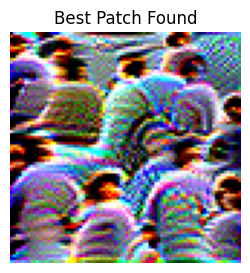

 Saved patched image WITHOUT detections: /content/drive/MyDrive/yolo_patch/FolderOptPatch_nodet.png
 Saved patched image WITH detections: /content/drive/MyDrive/yolo_patch/FolderOptPatch_withdet.png
 Saved clean image WITHOUT detections: /content/drive/MyDrive/yolo_patch/Clean_nodet.png
 Saved clean image WITH detections: /content/drive/MyDrive/yolo_patch/Clean_withdet.png


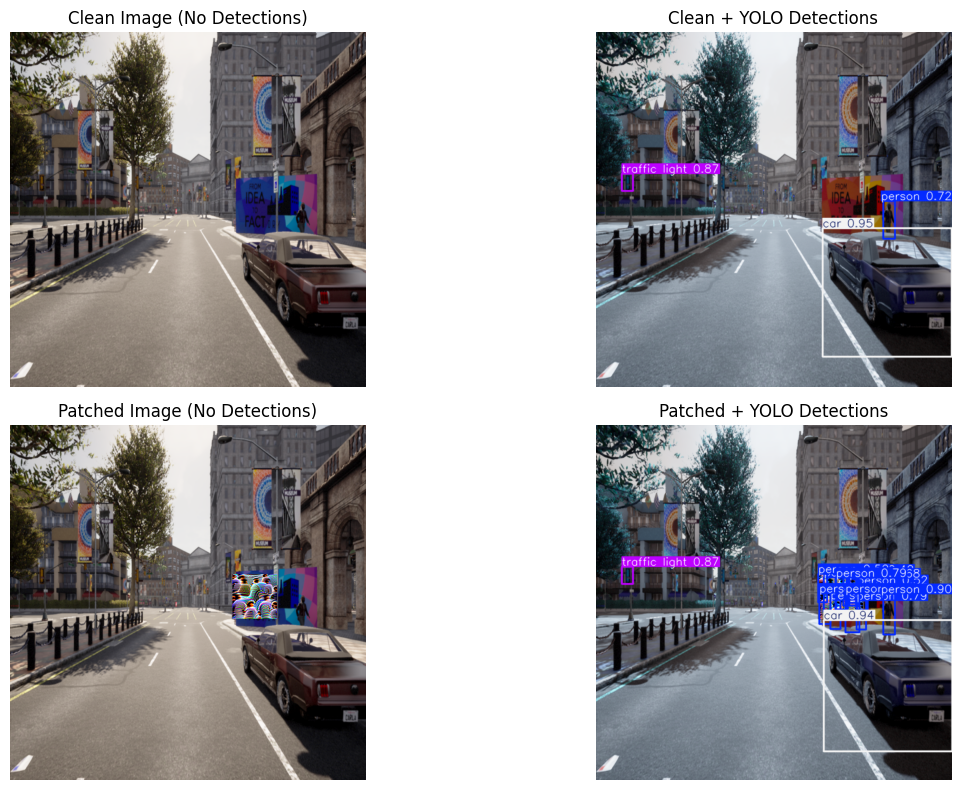

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os
from PIL import Image
import torch

# Load patch
patch = torch.load('/content/drive/MyDrive/best_patch4.pt')

# === Visualize the best patch ===
plt.figure(figsize=(3, 3))
plt.imshow(patch.permute(1, 2, 0).cpu().numpy())
plt.title("Best Patch Found")
plt.axis("off")
plt.show()

# === Overlay patch on image ===
patched = overlay_patch(image_tensor.clone(), patch.to(image_tensor.device), x_offset=400, y_offset=270)

# === Save patched image WITHOUT detections ===
patched_np = patched.clamp(0, 1).cpu().permute(1, 2, 0).numpy()
patched_pil = Image.fromarray((patched_np * 255).astype("uint8"))
patched_nodet_path = "/content/drive/MyDrive/yolo_patch/FolderOptPatch_nodet.png"
patched_pil.save(patched_nodet_path)
print(f" Saved patched image WITHOUT detections: {patched_nodet_path}")

# === Save patched image WITH detections ===
patched_det = model(patched.unsqueeze(0), verbose=False)
patched_boxes = patched_det[0].plot()
patched_boxes_rgb = cv2.cvtColor(patched_boxes, cv2.COLOR_BGR2RGB)
patched_det_path = "/content/drive/MyDrive/yolo_patch/FolderOptPatch_withdet.png"
Image.fromarray(patched_boxes_rgb).save(patched_det_path)
print(f" Saved patched image WITH detections: {patched_det_path}")

# === Run YOLO on clean image ===
clean_det = model(image_tensor.unsqueeze(0), verbose=False)
clean_boxes = clean_det[0].plot()
clean_boxes_rgb = cv2.cvtColor(clean_boxes, cv2.COLOR_BGR2RGB)

# === Save clean image WITHOUT detections ===
clean_np = image_tensor.clamp(0, 1).cpu().permute(1, 2, 0).numpy()
clean_pil = Image.fromarray((clean_np * 255).astype("uint8"))
clean_nodet_path = "/content/drive/MyDrive/yolo_patch/Clean_nodet.png"
clean_pil.save(clean_nodet_path)
print(f" Saved clean image WITHOUT detections: {clean_nodet_path}")

# === Save clean image WITH detections ===
clean_det_path = "/content/drive/MyDrive/yolo_patch/Clean_withdet.png"
Image.fromarray(clean_boxes_rgb).save(clean_det_path)
print(f" Saved clean image WITH detections: {clean_det_path}")

# === Plot all images ===
plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
plt.imshow(clean_np)
plt.title("Clean Image (No Detections)")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(clean_boxes_rgb)
plt.title("Clean + YOLO Detections")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.imshow(patched_np)
plt.title("Patched Image (No Detections)")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(patched_boxes_rgb)
plt.title("Patched + YOLO Detections")
plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as T
import cv2
import torch

# === Show the optimized patch ===
plt.figure(figsize=(3, 3))
plt.imshow(best_patch3.permute(1, 2, 0).cpu().numpy())
plt.title("Best Patch Found")
plt.axis("off")
plt.show()

# === Transform for YOLO input ===
transform = T.Compose([
    T.ToTensor(),
    T.Resize((640, 640)),
])

# === Random image paths ===
sample_paths = random.sample(image_paths, 5)

# === Create save directory ===
save_dir = "/content/drive/MyDrive/yolo_patch/compare"
os.makedirs(save_dir, exist_ok=True)

# === Plotting ===
plt.figure(figsize=(18, 15))

for idx, img_path in enumerate(sample_paths):
    # === Load & preprocess ===
    img = Image.open(img_path).convert("RGB")
    image_tensor = transform(img).to(best_patch3.device)

    # === Clean image — run YOLO ===
    with torch.no_grad():
        clean_results = model(image_tensor.unsqueeze(0), verbose=False)
    clean_with_boxes = clean_results[0].plot()
    clean_rgb = cv2.cvtColor(clean_with_boxes, cv2.COLOR_BGR2RGB)

    # === Patched image (no detections) ===
    patched_tensor = overlay_patch(image_tensor.clone(), best_patch3, x_offset=495, y_offset=250)
    patched_rgb = patched_tensor.permute(1, 2, 0).cpu().numpy()
    patched_rgb = (patched_rgb * 255).astype("uint8")

    # ===  Patched + YOLO detections ===
    with torch.no_grad():
        patched_results = model(patched_tensor.unsqueeze(0), verbose=False)
    patched_with_boxes = patched_results[0].plot()
    patched_with_boxes_rgb = cv2.cvtColor(patched_with_boxes, cv2.COLOR_BGR2RGB)

    # === Save all 3 to Drive ===
    Image.fromarray(clean_rgb).save(os.path.join(save_dir, f"clean_{idx+1}.png"))
    Image.fromarray(patched_rgb).save(os.path.join(save_dir, f"patched_nodet_{idx+1}.png"))
    Image.fromarray(patched_with_boxes_rgb).save(os.path.join(save_dir, f"patched_det_{idx+1}.png"))

    # === Show side-by-side in row ===
    plt.subplot(len(sample_paths), 3, idx * 3 + 1)
    plt.imshow(clean_rgb)
    plt.title(f"Image {idx+1} - Clean")
    plt.axis("off")

    plt.subplot(len(sample_paths), 3, idx * 3 + 2)
    plt.imshow(patched_rgb)
    plt.title("Patched (No Dets)")
    plt.axis("off")

    plt.subplot(len(sample_paths), 3, idx * 3 + 3)
    plt.imshow(patched_with_boxes_rgb)
    plt.title("Patched + YOLO")
    plt.axis("off")

plt.suptitle("Clean vs Patched (w/ & w/o YOLO Detections)", fontsize=18)
plt.tight_layout()
plt.show()

print(f"All images saved to: {save_dir}")


NameError: name 'best_patch3' is not defined

<Figure size 300x300 with 0 Axes>


## Create a dataset with patched images

In [ ]:
import os
import shutil
from PIL import Image
from torchvision import transforms
from torchvision.utils import save_image
import torch
import glob

# === Paths ===
patch_path = '/content/drive/MyDrive/best_patch4.pt'
images_dir = '/content/drive/MyDrive/2dod/2dod/billboard02/images/test_nopatch'
labels_dir = '/content/drive/MyDrive/2dod/2dod/billboard02/labels/test_nopatch'

# Destination YOLO-style structure
base_dir = '/content/patched_dataset'
patched_images_dir = os.path.join(base_dir, 'images/test')
patched_labels_dir = os.path.join(base_dir, 'labels/test')
os.makedirs(patched_images_dir, exist_ok=True)
os.makedirs(patched_labels_dir, exist_ok=True)

# === Load patch ===
import torch

best_patch3 = torch.load(patch_path, map_location="cpu")

# Move to GPU if available
if torch.cuda.is_available():
    best_patch3 = patch.to("cuda")

print(f"Loaded patch on device: {patch.device}")



# === Transforms ===
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((640, 640)),
])

# === Overlay patch function (you already have this) ===
def overlay_patch(image_tensor, patch, x_offset=300, y_offset=300):
    patched = image_tensor.clone()
    C, H, W = patch.shape
    patched[:, y_offset:y_offset+H, x_offset:x_offset+W] = patch

    return patched

# === Loop through images ===
image_paths = sorted(glob.glob(os.path.join(images_dir, "*.png")))
for img_path in image_paths:
    img_name = os.path.basename(img_path)
    label_name = img_name.replace(".png", ".txt")

    # Load and patch image
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).to("cuda")
    patched_tensor = overlay_patch(img_tensor, patch, x_offset=300, y_offset=300)

    # Save patched image
    save_image(patched_tensor, os.path.join(patched_images_dir, img_name))

    # Copy corresponding label
    shutil.copy(os.path.join(labels_dir, label_name), os.path.join(patched_labels_dir, label_name))

print(" Patched dataset created at:", base_dir)


Loaded patch on device: cpu
 Patched dataset created at: /content/patched_dataset


In [ ]:
# === Copy patched dataset to Google Drive ===
drive_target = "/content/drive/MyDrive/patched_dataset2"
if os.path.exists(drive_target):
    shutil.rmtree(drive_target)
shutil.copytree(base_dir, drive_target)
print(f"Also copied to Google Drive at: {drive_target}")


✅ Also copied to Google Drive at: /content/drive/MyDrive/patched_dataset2


In [ ]:
yaml_content = """\
path: "/content/drive/MyDrive/patched_dataset2"
train: /content/drive/MyDrive/2dod/2dod/train.txt
val: /content/drive/MyDrive/2dod/2dod/val.txt
test: "/content/drive/MyDrive/patched_dataset2"

names:
  0: person
  1: bicycle
  2: car
  3: motorcycle
  4: airplane
  5: bus
  6: train
  7: truck
  8: boat
  9: traffic light
  10: fire hydrant
  11: stop sign
  12: parking meter
  13: bench
  14: bird
  15: cat
  16: dog
  17: horse
  18: sheep
  19: cow
  20: elephant
  21: bear
  22: zebra
  23: giraffe
  24: backpack
  25: umbrella
  26: handbag
  27: tie
  28: suitcase
  29: frisbee
  30: skis
  31: snowboard
  32: sports ball
  33: kite
  34: baseball bat
  35: baseball glove
  36: skateboard
  37: surfboard
  38: tennis racket
  39: bottle
  40: wine glass
  41: cup
  42: fork
  43: knife
  44: spoon
  45: bowl
  46: banana
  47: apple
  48: sandwich
  49: orange
  50: broccoli
  51: carrot
  52: hot dog
  53: pizza
  54: donut
  55: cake
  56: chair
  57: couch
  58: potted plant
  59: bed
  60: dining table
  61: toilet
  62: tv
  63: laptop
  64: mouse
  65: remote
  66: keyboard
  67: cell phone
  68: microwave
  69: oven
  70: toaster
  71: sink
  72: refrigerator
  73: book
  74: clock
  75: vase
  76: scissors
  77: teddy bear
  78: hair drier
  79: toothbrush
"""

with open("/content/drive/MyDrive/2dod/2dod/testYOLO.yaml", "w") as f:
    f.write(yaml_content)

print("testYOLO.yaml created.")



testYOLO.yaml created.


In [ ]:
# Run evaluation
results = model.val(data="/content/drive/MyDrive/2dod/2dod/testYOLO.yaml", split="test")

# Define result container
test_results = {}
name = "patched"  # or "clean", "baseline", etc.

# Save metrics
test_results[name] = {
    "mAP50": results.box.map50,
    "mAP50-95": results.box.map,
    "Precision": results.box.p,
    "Recall": results.box.r
}



Ultralytics 8.3.169 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.2±0.0 ms, read: 284.0±7.5 MB/s, size: 620.8 KB)


val: Scanning /content/drive/MyDrive/patched_dataset2/labels/test... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<00:00, 322.16it/s]

val: New cache created: /content/drive/MyDrive/patched_dataset2/labels/test.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.41it/s]


                   all         50        244       0.61      0.654      0.733      0.392
                person         24         35     0.0445        0.6      0.569      0.252
                   car         50        133       0.92       0.85      0.944      0.593
            motorcycle         30         76      0.866      0.513      0.687       0.33
Speed: 4.1ms preprocess, 23.5ms inference, 0.0ms loss, 8.1ms postprocess per image
Results saved to runs/detect/val6


          image  clean_detections  patched_detections
0  rgb_0000.png                 4                  16
1  rgb_0001.png                 8                  15
2  rgb_0002.png                 4                  15
3  rgb_0003.png                 2                  15
4  rgb_0004.png                 5                  14


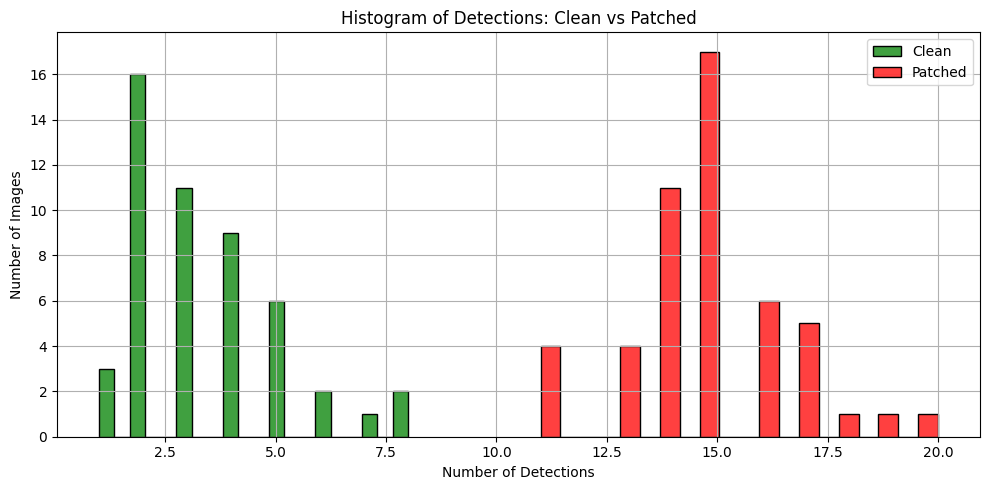

In [ ]:
import os
import torch
import random
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as T
from ultralytics import YOLO
import pandas as pd
import seaborn as sns

# === Config ===
clean_image_dir = "/content/drive/MyDrive/2dod/2dod/billboard01/images/test_nopatch"
patched_image_dir = "/content/patched_dataset/images/test"
device = "cuda" if torch.cuda.is_available() else "cpu"
model_path = "/content/drive/MyDrive/yolo_trained_models/2dod_checkpoints/best.pt"

# === Load model ===
model = YOLO(model_path)
transform = T.Compose([T.ToTensor(), T.Resize((640, 640))])

# === List image files ===
clean_images = sorted([f for f in os.listdir(clean_image_dir) if f.endswith(".png") or f.endswith(".jpg")])
patched_images = sorted([f for f in os.listdir(patched_image_dir) if f.endswith(".png") or f.endswith(".jpg")])

# === Sanity check ===
assert clean_images == patched_images, "Image filenames must match between clean and patched sets."

# === Accumulators ===
image_names = []
clean_detections = []
patched_detections = []

# === Evaluation loop ===
for filename in clean_images:
    image_names.append(filename)

    # Load clean image
    clean_img_path = os.path.join(clean_image_dir, filename)
    clean_tensor = transform(Image.open(clean_img_path).convert("RGB")).to(device)
    results_clean = model(clean_tensor.unsqueeze(0), verbose=False)
    num_clean = len(results_clean[0].boxes)
    clean_detections.append(num_clean)

    # Load patched image
    patched_img_path = os.path.join(patched_image_dir, filename)
    patched_tensor = transform(Image.open(patched_img_path).convert("RGB")).to(device)
    results_patched = model(patched_tensor.unsqueeze(0), verbose=False)
    num_patched = len(results_patched[0].boxes)
    patched_detections.append(num_patched)

# === Save results to DataFrame ===
df = pd.DataFrame({
    "image": image_names,
    "clean_detections": clean_detections,
    "patched_detections": patched_detections
})
print(df.head())

# === Plot histogram ===
plt.figure(figsize=(10, 5))
sns.histplot(df["clean_detections"], color="green", label="Clean", kde=False, bins=20)
sns.histplot(df["patched_detections"], color="red", label="Patched", kde=False, bins=20)
plt.title("Histogram of Detections: Clean vs Patched")
plt.xlabel("Number of Detections")
plt.ylabel("Number of Images")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Local Gradient Smoothing (LGS) Defense

This function implements **Local Gradient Smoothing (LGS)** — a defense strategy that suppresses adversarial perturbations by selectively blurring high-frequency (edge-like) regions in an image.

---

#### How it Works

1. **Grayscale Conversion**  
   - The input image is converted to grayscale to compute spatial gradients.

2. **Gradient Magnitude Calculation**  
   - Horizontal and vertical edges are detected using Sobel filters (`grad_x`, `grad_y`).  
   - The magnitude of the gradient is computed and normalized to highlight strong edges.

3. **Thresholding (Mask Generation)**  
   - A binary mask is created by thresholding the gradient magnitude.  
   - This mask identifies "edge-like" regions where adversarial noise is most likely present.

4. **Morphological Mask Refinement** *(optional)*  
   - The binary mask can be smoothed using morphological operations to reduce noise.

5. **Selective Gaussian Smoothing**  
   - The image is fully blurred using a Gaussian filter.  
   - Pixels in non-edge areas are kept original, while edge areas are replaced with their blurred versions.

6. **Debug Visualization** *(optional)*  
   - If `debug=True`, the function will display:
     - Original input
     - Gradient heatmap
     - Binary mask
     - Final smoothed image

---

#### Parameters

- `sigma`: Strength of the Gaussian blur (larger = stronger smoothing).
- `threshold`: Controls edge sensitivity (lower = more aggressive mask).
- `morph_kernel_size`: Size of the kernel used for optional morphological cleanup.
- `debug`: Set to `True` to visualize intermediate results.

---

#### Usage

This function is typically applied **before inference** on potentially adversarial images to reduce detection of imperceptible noise without harming clean features. It’s lightweight, differentiable, and effective as a simple preprocessing step.

https://github.com/icyham/local_gradients_smoothing/blob/master/lgs.ipynb

In [ ]:
import torch
import numpy as np
import cv2

def apply_lgs(
    image_tensor,
    sigma=1.5,
    threshold=0.05,
    morph_kernel_size=3,
    debug=False
):
    """
    Apply Local Gradient Smoothing (LGS) to suppress adversarial noise.

    Args:
        image_tensor (Tensor): Image tensor with shape (C, H, W), values in [0, 1].
        sigma (float): Standard deviation for Gaussian blur.
        threshold (float): Gradient threshold to activate the mask.
        morph_kernel_size (int): Optional kernel size for morphological mask refinement.
        debug (bool): If True, show visualization of intermediate steps.

    Returns:
        Tensor: LGS-processed image (same shape as input).
    """

    assert image_tensor.ndim == 3, "Input should be (C, H, W)"
    image_np = image_tensor.detach().cpu().numpy().transpose(1, 2, 0)  # → (H, W, C)
    image_np = np.clip(image_np, 0, 1)

    # Convert to grayscale
    gray = cv2.cvtColor((image_np * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

    # Compute gradient magnitude
    grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    grad_mag = np.sqrt(grad_x**2 + grad_y**2)
    grad_norm = grad_mag / (grad_mag.max() + 1e-8)

    # Threshold to create binary mask
    mask = (grad_norm > threshold).astype(np.uint8)

    # Optional: refine mask with morphological operations
    if morph_kernel_size > 0:
        kernel = np.ones((morph_kernel_size, morph_kernel_size), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    # Gaussian blur the full image
    blurred = cv2.GaussianBlur(image_np, (0, 0), sigmaX=sigma, sigmaY=sigma)

    # Apply mask: keep original in low-gradient, blur in high-gradient
    result_np = image_np * (1 - mask[:, :, None]) + blurred * mask[:, :, None]

    # Optional debug plot
    if debug:
        import matplotlib.pyplot as plt
        plt.figure(figsize=(15, 4))
        plt.subplot(1, 4, 1)
        plt.imshow(image_np)
        plt.title("Original")
        plt.axis("off")

        plt.subplot(1, 4, 2)
        plt.imshow(grad_norm, cmap='hot')
        plt.title("Gradient Magnitude")
        plt.axis("off")

        plt.subplot(1, 4, 3)
        plt.imshow(mask, cmap='gray')
        plt.title("LGS Mask")
        plt.axis("off")

        plt.subplot(1, 4, 4)
        plt.imshow(result_np)
        plt.title("LGS Output")
        plt.axis("off")
        plt.tight_layout()
        plt.show()

    # Convert back to tensor
    result_tensor = torch.from_numpy(result_np.transpose(2, 0, 1)).float().to(image_tensor.device)
    return result_tensor.clamp(0, 1)


Post-LGS min/max: 0.0 1.0


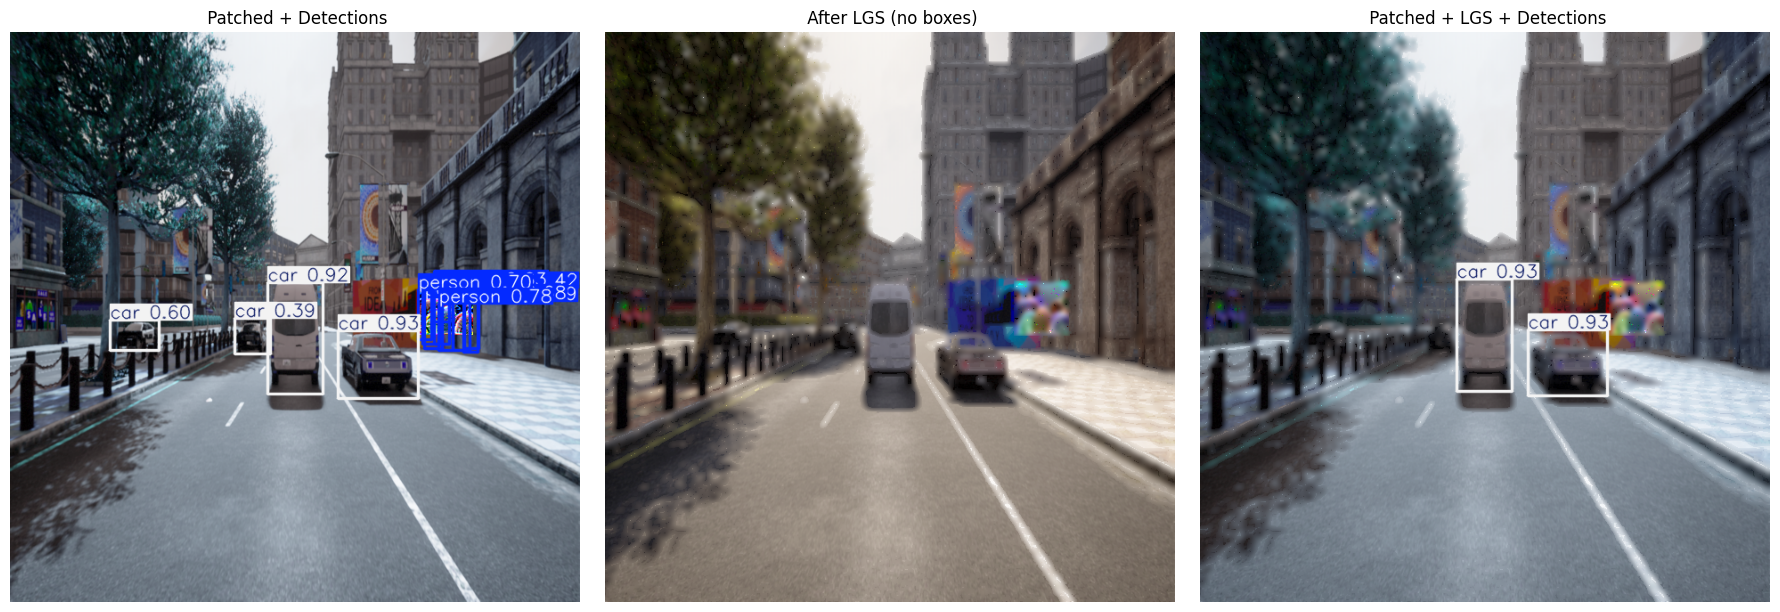

 Results saved to /content/drive/MyDrive/yolo_patch/compare_lgs
 Detections BEFORE LGS: 13
 Detections AFTER LGS : 2


In [ ]:
import numpy as np
import cv2


# --- transform to YOLO input size ---
transform = T.Compose([
    T.ToTensor(),
    T.Resize((640, 640)),
])

patch_path = '/content/drive/MyDrive/best_patch3.pt'
best_patch3 = torch.load(patch_path, map_location="cpu")

# --- pick a random image & patch it ---
img_path = random.choice(image_paths)
img = Image.open(img_path).convert("RGB")
image_tensor = transform(img).to(best_patch3.device)

patched_tensor = overlay_patch(
    image_tensor.clone(),
    best_patch3.clamp(0, 1),  # safety clamp
    x_offset=460, y_offset=280
)

# ========== ① Run YOLO on the *patched* image ==========
with torch.no_grad():
    patched_results = model(patched_tensor.unsqueeze(0), verbose=False)

patched_det_img = patched_results[0].plot()                         # BGR
patched_det_rgb = cv2.cvtColor(patched_det_img, cv2.COLOR_BGR2RGB)  # RGB for plt

# ========== ② Apply LGS ==========
patched_defended = apply_lgs(patched_tensor, sigma=2.8, threshold=0.02)
print("Post-LGS min/max:", patched_defended.min().item(), patched_defended.max().item())

# --- quick preview of LGS output ---
lgs_rgb = (patched_defended.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)

# ========== ③ Run YOLO on the LGS-defended image ==========
with torch.no_grad():
    lgs_results = model(patched_defended.unsqueeze(0), verbose=False)

lgs_det_img = lgs_results[0].plot()
lgs_det_rgb = cv2.cvtColor(lgs_det_img, cv2.COLOR_BGR2RGB)

# ======================== PLOT ALL THREE ========================
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(patched_det_rgb)
plt.title(" Patched + Detections")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(lgs_rgb)
plt.title(" After LGS (no boxes)")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(lgs_det_rgb)
plt.title(" Patched + LGS + Detections")
plt.axis("off")

plt.tight_layout()
plt.show()

# --- save outputs to Drive (optional) ---
save_dir = "/content/drive/MyDrive/yolo_patch/compare_lgs"
os.makedirs(save_dir, exist_ok=True)
Image.fromarray(patched_det_rgb).save(os.path.join(save_dir, "patched_with_boxes.png"))
Image.fromarray(lgs_rgb).save(os.path.join(save_dir, "after_lgs_no_boxes.png"))
Image.fromarray(lgs_det_rgb).save(os.path.join(save_dir, "lgs_with_boxes.png"))

print(f" Results saved to {save_dir}")
# Count how many detections survived (confidence > 0.2)
patched_num_dets = sum(p[4] > 0.2 for p in patched_results[0].boxes.data)
lgs_num_dets = sum(p[4] > 0.2 for p in lgs_results[0].boxes.data)

print(f" Detections BEFORE LGS: {patched_num_dets}")
print(f" Detections AFTER LGS : {lgs_num_dets}")


### Evaluating the Effect of LGS on Clean Images

To understand the impact of the Local Gradient Smoothing (LGS) defense on clean (unmodified) images, we applied our trained YOLOv8 model on each image before and after applying LGS. This helps assess whether LGS preserves model performance on benign inputs.

The average number of detections per image is reported below.


In [ ]:
from PIL import Image
from torchvision import transforms
import torch

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((640, 640))
])

total_detections_clean = 0
total_detections_defended = 0
num_images = len(image_paths)

for img_path in image_paths:
    # Load and transform clean image
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to("cuda")  # Add batch dim

    # Get detections on clean image
    with torch.no_grad():
        preds_clean = model.model(img_tensor)[0]
        detections_clean = (preds_clean[:, 4] > 0.3).sum().item()
        total_detections_clean += detections_clean

    # Apply LGS
    defended_tensor = apply_lgs(img_tensor.squeeze(0))  # Remove batch before LGS
    defended_tensor = defended_tensor.unsqueeze(0).to("cuda")

    # Get detections on defended clean image
    with torch.no_grad():
        preds_defended = model.model(defended_tensor)[0]
        detections_defended = (preds_defended[:, 4] > 0.3).sum().item()
        total_detections_defended += detections_defended

# Average results
avg_clean = total_detections_clean / num_images
avg_defended = total_detections_defended / num_images

print(f" Clean images - Avg detections: {avg_clean:.2f}")
print(f"  Clean + LGS - Avg detections: {avg_defended:.2f}")


 Clean images - Avg detections: 5.02
  Clean + LGS - Avg detections: 4.22


In [ ]:
import glob
import os
from PIL import Image
import torch
from torchvision import transforms

# Load the best adversarial patch
patch_path = '/content/drive/MyDrive/best_patch3.pt'
images_dir = "/content/drive/MyDrive/2dod/2dod/billboard01/images/test_nopatch"
patch = torch.load(patch_path).to("cuda")

# Image preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((640, 640)),
])

image_paths = sorted(glob.glob(os.path.join(images_dir, "*.png")))
num_images = len(image_paths)

total_detections = 0
total_detections_lgs = 0

for img_path in image_paths:
    img = Image.open(img_path).convert("RGB")
    image_tensor = transform(img).to(patch.device)

    # Overlay the patch
    patched_tensor = overlay_patch(image_tensor, patch, x_offset=300, y_offset=300)
    patched_tensor = patched_tensor.unsqueeze(0)

    #  Evaluate without LGS
    with torch.no_grad():
        preds = model.model(patched_tensor)[0]
        detections = (preds[:, 4] > 0.3).sum().item()
        total_detections += detections

    #  Apply LGS defense
    defended_tensor = apply_lgs(patched_tensor.squeeze(0), sigma=3.0, threshold=0.02)
    defended_tensor = defended_tensor.unsqueeze(0)

    #  Evaluate with LGS
    with torch.no_grad():
        preds_defended = model.model(defended_tensor)[0]
        detections_defended = (preds_defended[:, 4] > 0.3).sum().item()
        total_detections_lgs += detections_defended

#  Print results
print(f" Patch evaluation on folder '{images_dir}'")
print(f" Images evaluated: {num_images}")
print(f" Avg detections per image (w/ patch): {total_detections / num_images:.2f}")
print(f" Avg detections per image (w/ patch + LGS): {total_detections_lgs / num_images:.2f}")


🎯 Patch evaluation on folder '/content/drive/MyDrive/2dod/2dod/billboard01/images/test_nopatch'
📸 Images evaluated: 50
🔍 Avg detections per image (w/ patch): 60.20
🛡️ Avg detections per image (w/ patch + LGS): 0.88


In [ ]:
import os
from PIL import Image
import torchvision.transforms as T
import torch
from tqdm import tqdm

# === Paths ===
patched_dir = "/content/patched_dataset/images/test"
patched_label_dir = "/content/patched_dataset/labels/test"

lgs_dir = "/content/lgs_defended_dataset/images/test"
lgs_label_dir = "/content/lgs_defended_dataset/labels/test"

# === Make output folders ===
os.makedirs(lgs_dir, exist_ok=True)
os.makedirs(lgs_label_dir, exist_ok=True)

# === Transform to tensor ===
transform = T.Compose([
    T.ToTensor(),
    T.Resize((640, 640)),
])

# === Reverse to image ===
to_pil = T.ToPILImage()

# === Process all images ===
image_files = sorted([f for f in os.listdir(patched_dir) if f.endswith((".png", ".jpg"))])

for filename in tqdm(image_files, desc="Applying LGS to patched images"):
    # Load image and convert
    img_path = os.path.join(patched_dir, filename)
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).to(torch.float32)

    # Apply LGS
    img_lgs = apply_lgs(patched_tensor, sigma=2.5, threshold=0.02)

    # Save defended image
    out_img = to_pil(img_lgs.clamp(0, 1).cpu())
    out_img.save(os.path.join(lgs_dir, filename))

    # Copy label file
    label_filename = filename.rsplit(".", 1)[0] + ".txt"
    src_label = os.path.join(patched_label_dir, label_filename)
    dst_label = os.path.join(lgs_label_dir, label_filename)
    if os.path.exists(src_label):
        os.system(f"cp {src_label} {dst_label}")


FileNotFoundError: [Errno 2] No such file or directory: '/content/patched_dataset/images/test'

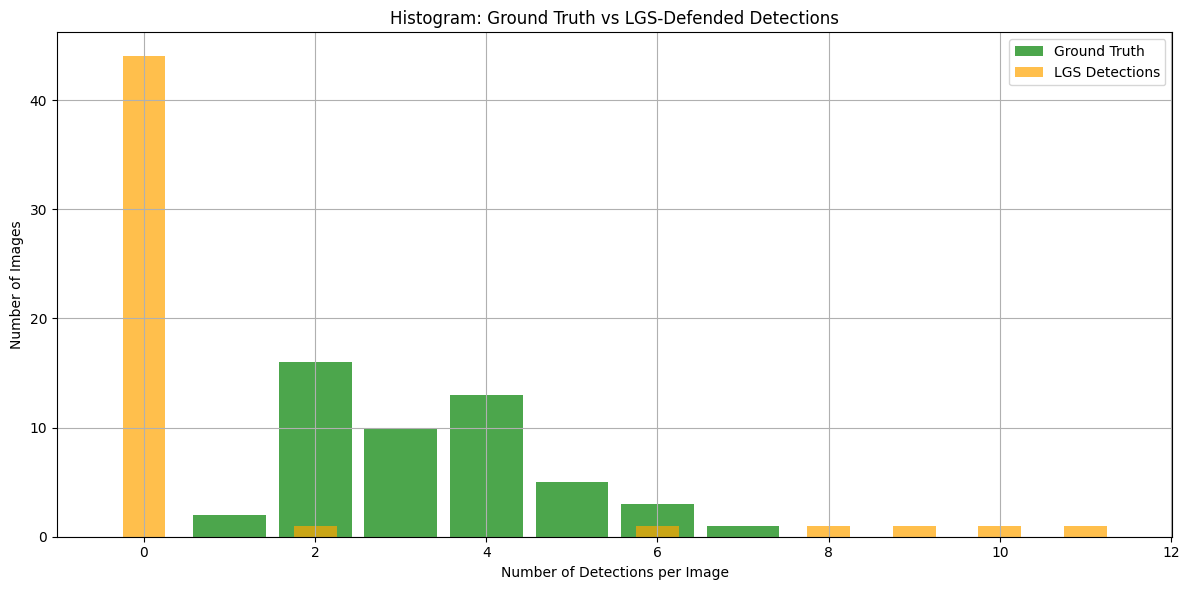

✅ Processed 50 images
📦 LGS-defended dataset saved to: /content/drive/MyDrive/lgs_defended_dataset/images/test
🔍 Avg GT detections: 3.32
🛡️ Avg LGS detections: 0.92


In [ ]:
import glob
import os
from PIL import Image
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np

# === Paths ===
patch_path = '/content/drive/MyDrive/best_patch3.pt'
images_dir = "/content/drive/MyDrive/2dod/2dod/billboard01/images/test_nopatch"
labels_dir = "/content/drive/MyDrive/2dod/2dod/billboard01/labels/test_nopatch"
save_dir = "/content/drive/MyDrive/lgs_defended_dataset/images/test"

# === Load patch and setup ===
patch = torch.load(patch_path).to("cuda")
os.makedirs(save_dir, exist_ok=True)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((640, 640)),
])

image_paths = sorted(glob.glob(os.path.join(images_dir, "*.png")))
num_images = len(image_paths)

gt_detections = []
lgs_detections = []

for img_path in image_paths:
    img = Image.open(img_path).convert("RGB")
    image_tensor = transform(img).to(patch.device)

    # === Get ground truth label count ===
    label_path = os.path.join(labels_dir, os.path.basename(img_path).replace(".png", ".txt"))
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            gt = len([line for line in f if line.strip()])
    else:
        gt = 0
    gt_detections.append(gt)

    # === Apply patch + LGS ===
    patched_tensor = overlay_patch(image_tensor, patch, x_offset=300, y_offset=300).unsqueeze(0)
    defended_tensor = apply_lgs(patched_tensor.squeeze(0), sigma=2.9, threshold=0.02).unsqueeze(0)

    # === Run YOLO on LGS image ===
    with torch.no_grad():
        preds = model.model(defended_tensor)[0]
        detected = (preds[:, 4] > 0.3).sum().item()
        lgs_detections.append(detected)

    # === Save defended image ===
    defended_np = defended_tensor.squeeze(0).clamp(0, 1).cpu().permute(1, 2, 0).numpy()
    defended_pil = Image.fromarray((defended_np * 255).astype("uint8"))
    img_name = os.path.basename(img_path)
    defended_pil.save(os.path.join(save_dir, img_name))

# === Histogram Plot ===
all_vals = gt_detections + lgs_detections
bins = np.arange(min(all_vals), max(all_vals)+2) - 0.5

plt.figure(figsize=(12, 6))
plt.hist(gt_detections, bins=bins, alpha=0.7, label='Ground Truth', color='green', rwidth=0.85)
plt.hist(lgs_detections, bins=bins, alpha=0.7, label='LGS Detections', color='orange', rwidth=0.5)
plt.xlabel("Number of Detections per Image")
plt.ylabel("Number of Images")
plt.title("Histogram: Ground Truth vs LGS-Defended Detections")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# === Summary ===
print(f"✅ Processed {num_images} images")
print(f"📦 LGS-defended dataset saved to: {save_dir}")
print(f"🔍 Avg GT detections: {np.mean(gt_detections):.2f}")
print(f"🛡️ Avg LGS detections: {np.mean(lgs_detections):.2f}")


Running on LGS-defended set: 0it [00:00, ?it/s]
/tmp/ipython-input-37-3471160660.py:69: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


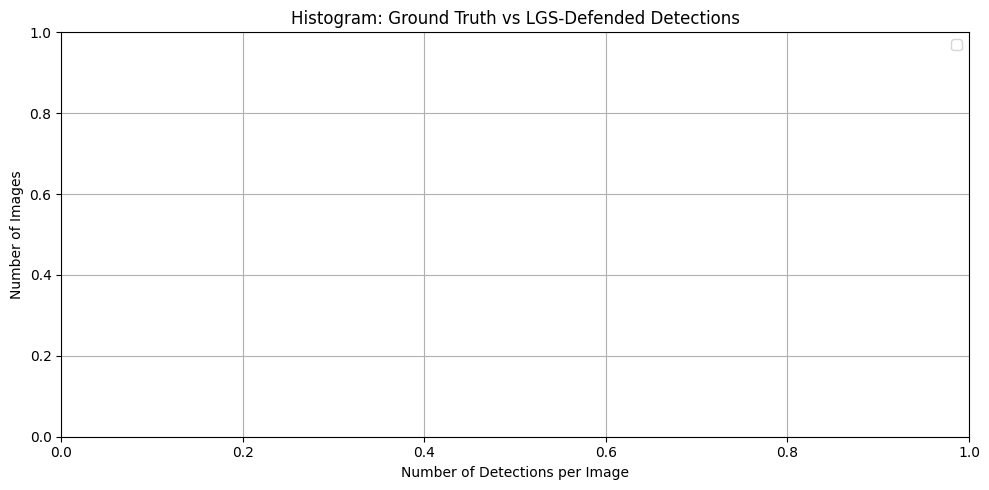

Empty DataFrame
Columns: [image, ground_truth, lgs_detections]
Index: []

In [ ]:
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from ultralytics import YOLO
import torchvision.transforms as T

# === Paths ===
gt_label_dir = "/content/patched_dataset/labels/test"
lgs_image_dir = "/content/lgs_defended_dataset/images/test"

# === Model ===
model = YOLO("/content/drive/MyDrive/yolo_trained_models/2dod_checkpoints/best.pt")
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# === Transform ===
transform = T.Compose([
    T.ToTensor(),
    T.Resize((640, 640)),
])

# === Gather filenames ===
image_files = sorted([f for f in os.listdir(lgs_image_dir) if f.endswith((".jpg", ".png"))])

# === Storage ===
image_names = []
gt_counts = []
lgs_detections = []

# === Process images ===
for fname in tqdm(image_files, desc="Running on LGS-defended set"):
    image_names.append(fname)
    stem = fname.rsplit(".", 1)[0]

    # Ground truth
    label_file = os.path.join(gt_label_dir, f"{stem}.txt")
    if os.path.exists(label_file):
        with open(label_file, "r") as f:
            gt = len(f.readlines())
    else:
        gt = 0
    gt_counts.append(gt)

    # Image + YOLO inference
    img = Image.open(os.path.join(lgs_image_dir, fname)).convert("RGB")
    tensor = transform(img).to(device)
    with torch.no_grad():
        result = model(tensor.unsqueeze(0), verbose=False)
    lgs_detections.append(len(result[0].boxes))

# === Create DataFrame ===
import seaborn as sns
df = pd.DataFrame({
    "image": image_names,
    "ground_truth": gt_counts,
    "lgs_detections": lgs_detections
})

# === Plot ===
plt.figure(figsize=(10, 5))
sns.histplot(df["ground_truth"], bins=20, color="green", label="Ground Truth", kde=False)
sns.histplot(df["lgs_detections"], bins=20, color="orange", label="LGS Detections", kde=False)
plt.xlabel("Number of Detections per Image")
plt.ylabel("Number of Images")
plt.title("Histogram: Ground Truth vs LGS-Defended Detections")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: see data
df.head()
